In [54]:
from scapy.all import *
import pandas as pd
import numpy as np
import binascii
import seaborn as sns
%matplotlib inline
from scapy.layers.l2 import Ether
from scapy.layers.inet import IP
from scapy.layers.inet import TCP, UDP
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
from sklearn import metrics, model_selection, tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from ydata_profiling import ProfileReport
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

In [2]:
pcap_file = rdpcap('analisis_paquetes.pcap')

In [3]:
num_of_packets_to_sniff = 100
pcap_scan = sniff(count=num_of_packets_to_sniff)

In [4]:
for packet in pcap_file:
    print(packet.src)

88:e9:fe:6a:92:52
80:37:73:96:9b:db
88:e9:fe:6a:92:52
80:37:73:96:9b:db
88:e9:fe:6a:92:52
80:37:73:96:9b:db
88:e9:fe:6a:92:52
80:37:73:96:9b:db
88:e9:fe:6a:92:52
80:37:73:96:9b:db
88:e9:fe:6a:92:52
80:37:73:96:9b:db
88:e9:fe:6a:92:52
80:37:73:96:9b:db
88:e9:fe:6a:92:52
80:37:73:96:9b:db
88:e9:fe:6a:92:52
80:37:73:96:9b:db
88:e9:fe:6a:92:52
80:37:73:96:9b:db
88:e9:fe:6a:92:52
80:37:73:96:9b:db
88:e9:fe:6a:92:52
88:e9:fe:6a:92:52
80:37:73:96:9b:db
80:37:73:96:9b:db
88:e9:fe:6a:92:52
80:37:73:96:9b:db
88:e9:fe:6a:92:52
80:37:73:96:9b:db
88:e9:fe:6a:92:52
80:37:73:96:9b:db
88:e9:fe:6a:92:52
80:37:73:96:9b:db
88:e9:fe:6a:92:52
80:37:73:96:9b:db
88:e9:fe:6a:92:52
80:37:73:96:9b:db
88:e9:fe:6a:92:52
80:37:73:96:9b:db
88:e9:fe:6a:92:52
80:37:73:96:9b:db
88:e9:fe:6a:92:52
80:37:73:96:9b:db
88:e9:fe:6a:92:52
80:37:73:96:9b:db
88:e9:fe:6a:92:52
80:37:73:96:9b:db
88:e9:fe:6a:92:52
80:37:73:96:9b:db
88:e9:fe:6a:92:52
80:37:73:96:9b:db
88:e9:fe:6a:92:52
80:37:73:96:9b:db
88:e9:fe:6a:92:52
80:37:73:9

In [5]:
ethernet_frame = pcap_file[0]
ip_packet = ethernet_frame.payload
segment = ip_packet.payload
data = segment.payload 

print("Informacion del frame:")
print(ethernet_frame.summary())

print("Informacion del paquete:")
print(ip_packet.summary())

print("Informacion del segmento:")
print(segment.summary())

print("Data:")
print(data.summary())

ethernet_frame.show()
data.show()

Informacion del frame:
Ether / IP / UDP / DNS Qry "b'google.com.'"  / Raw
Informacion del paquete:
IP / UDP / DNS Qry "b'google.com.'"  / Raw
Informacion del segmento:
UDP / DNS Qry "b'google.com.'"  / Raw
Data:
DNS Qry "b'google.com.'"  / Raw
###[ Ethernet ]### 
  dst       = 80:37:73:96:9b:db
  src       = 88:e9:fe:6a:92:52
  type      = IPv4
###[ IP ]### 
     version   = 4
     ihl       = 5
     tos       = 0x0
     len       = 961
     id        = 1
     flags     = 
     frag      = 0
     ttl       = 64
     proto     = udp
     chksum    = 0x52e6
     src       = 10.1.10.53
     dst       = 84.54.22.33
     \options   \
###[ UDP ]### 
        sport     = domain
        dport     = domain
        len       = 941
        chksum    = 0xf60e
###[ DNS ]### 
           id        = 12
           qr        = 0
           opcode    = QUERY
           aa        = 0
           tc        = 0
           rd        = 1
           ra        = 0
           z         = 0
           ad        = 

In [6]:
print(type(ethernet_frame))
print(type(ip_packet))
print(type(segment))

ethernet_type = type(ethernet_frame)
ip_type = type(ip_packet)
tcp_type = type(segment)

print("Ethernet", pcap_file[ethernet_type])
print("IP", pcap_file[ip_type])
print("TCP", pcap_file[tcp_type])

print("UDP", pcap_file[UDP])

<class 'scapy.layers.l2.Ether'>
<class 'scapy.layers.inet.IP'>
<class 'scapy.layers.inet.UDP'>
Ethernet <Ether from analisis_paquetes.pcap: TCP:0 UDP:62 ICMP:0 Other:0>
IP <IP from analisis_paquetes.pcap: TCP:0 UDP:62 ICMP:0 Other:0>
TCP <UDP from analisis_paquetes.pcap: TCP:0 UDP:62 ICMP:0 Other:0>
UDP <UDP from analisis_paquetes.pcap: TCP:0 UDP:62 ICMP:0 Other:0>


In [7]:
def create_dataframe(pcap_packets):
    ip_fields = [field.name for field in IP().fields_desc]
    tcp_fields = [field.name for field in TCP().fields_desc]
    udp_fields = [field.name for field in UDP().fields_desc]

    dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload', 'payload_raw', 'payload_hex']

    df = pd.DataFrame(columns=dataframe_fields)
    for packet in pcap_packets[IP]:
        field_values = []
        for field in ip_fields:
            if field == 'options':
                field_values.append(len(packet[IP].fields[field]))
            else:
                field_values.append(packet[IP].fields[field])

        field_values.append(packet.time)

        layer_type = type(packet[IP].payload)
        for field in tcp_fields:
            try:
                if field == 'options':
                    field_values.append(len(packet[layer_type].fields[field]))
                else:
                    field_values.append(packet[layer_type].fields[field])
            except:
                field_values.append(None)

        field_values.append(len(packet[layer_type].payload))
        field_values.append(packet[layer_type].payload.original)
        field_values.append(binascii.hexlify(packet[layer_type].payload.original))
        df_append = pd.DataFrame([field_values], columns=dataframe_fields)
        df = pd.concat([df, df_append], axis=0)

    df = df.reset_index()
    df = df.drop(columns="index")
    
    return df

In [8]:
df_file = create_dataframe(pcap_file)
df_file.sample(10)

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
61,4,5,32,84,10094,,0,122,17,62661,...,None,None,None,None,65090,None,None,56,b'\x00\x0c\x81\x80\x00\x01\x00\x01\x00\x00\x00...,b'000c8180000100010000000006676f6f676c6503636f...
42,4,5,0,1010,1,,0,64,17,21173,...,None,None,None,None,45536,None,None,982,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
32,4,5,0,1037,1,,0,64,17,21146,...,None,None,None,None,14360,None,None,1009,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
58,4,5,0,969,1,,0,64,17,21214,...,None,None,None,None,671,None,None,941,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
29,4,5,32,84,196,,0,122,17,7024,...,None,None,None,None,65074,None,None,56,b'\x00\x0c\x81\x80\x00\x01\x00\x01\x00\x00\x00...,b'000c8180000100010000000006676f6f676c6503636f...
7,4,5,32,84,60495,,0,122,17,12260,...,None,None,None,None,65065,None,None,56,"b""\x00\x0c\x81\x80\x00\x01\x00\x01\x00\x00\x00...",b'000c8180000100010000000006676f6f676c6503636f...
23,4,5,0,65,59922,,0,64,17,58829,...,None,None,None,None,20312,None,None,37,b'Q\x19\x01\x00\x00\x01\x00\x00\x00\x00\x00\x0...,b'51190100000100000000000008636c69656e74733406...
41,4,5,32,84,4833,,0,122,17,2387,...,None,None,None,None,65080,None,None,56,b'\x00\x0c\x81\x80\x00\x01\x00\x01\x00\x00\x00...,b'000c8180000100010000000006676f6f676c6503636f...
38,4,5,0,1037,1,,0,64,17,21146,...,None,None,None,None,34323,None,None,1009,"b""\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...",b'000c0100000100000000000006676f6f676c6503636f...
44,4,5,0,1006,1,,0,64,17,21177,...,None,None,None,None,49529,None,None,978,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...


In [9]:
df_scan = create_dataframe(pcap_scan)
df_scan.sample(10)

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
72,4,5,0,52,60684,,0,117,6,42267,...,8,0,A,265,28309,0,3,0,b'',b''
4,4,5,0,60,22568,DF,0,64,6,24951,...,10,0,S,64240,33099,0,5,0,b'',b''
11,4,5,0,52,8336,DF,0,107,6,28183,...,8,0,SA,65535,60006,0,6,0,b'',b''
10,4,5,0,557,22570,DF,0,64,6,24452,...,5,0,PA,502,33596,0,0,517,b'\x16\x03\x01\x02\x00\x01\x00\x01\xfc\x03\x03...,b'1603010200010001fc0303d88a0f408dcf6258fb5617...
86,4,5,0,52,50514,DF,0,64,6,24463,...,8,0,FA,3668,5641,0,3,0,b'',b''
0,4,5,0,102,20211,,0,64,17,3831,...,None,None,None,None,7425,None,None,74,b'\x9d\x03\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'9d0301000001000000000001106f6e656473636f6c70...
67,4,5,0,375,0,DF,0,1,17,25552,...,None,None,None,None,42567,None,None,347,b'NOTIFY * HTTP/1.1\r\nHOST:239.255.255.250:19...,b'4e4f54494659202a20485454502f312e310d0a484f53...
13,4,5,0,557,30934,DF,0,64,6,16088,...,5,0,PA,502,33596,0,0,517,"b""\x16\x03\x01\x02\x00\x01\x00\x01\xfc\x03\x03...",b'1603010200010001fc03035784206f6deaf89dce11b2...
52,4,5,0,52,6985,DF,0,64,6,19626,...,8,0,A,501,54007,0,3,0,b'',b''
1,4,5,0,102,64225,,0,64,17,25352,...,None,None,None,None,7425,None,None,74,b'Y^\x01\x00\x00\x01\x00\x00\x00\x00\x00\x01\x...,b'595e01000001000000000001106f6e656473636f6c70...


In [10]:
df = pd.concat([df_file, df_scan], ignore_index = True)
df

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
0,4,5,0,961,1,,0,64,17,21222,...,None,None,None,None,62990,None,None,933,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
1,4,5,32,84,58919,,0,122,17,13836,...,None,None,None,None,65061,None,None,56,b'\x00\x0c\x81\x80\x00\x01\x00\x01\x00\x00\x00...,b'000c8180000100010000000006676f6f676c6503636f...
2,4,5,0,975,1,,0,64,17,21208,...,None,None,None,None,36378,None,None,947,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
3,4,5,32,84,59493,,0,122,17,13262,...,None,None,None,None,65063,None,None,56,b'\x00\x0c\x81\x80\x00\x01\x00\x01\x00\x00\x00...,b'000c8180000100010000000006676f6f676c6503636f...
4,4,5,0,1012,1,,0,64,17,21171,...,None,None,None,None,63846,None,None,984,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,4,5,0,52,25130,DF,0,64,6,38847,...,8,0,FA,501,16641,0,3,0,b'',b''
150,4,5,0,52,62885,DF,0,64,6,4482,...,8,0,FA,501,13251,0,3,0,b'',b''
151,4,5,0,52,1250,DF,0,64,6,50563,...,8,0,FA,501,28805,0,3,0,b'',b''
152,4,5,0,52,39537,DF,0,64,6,4079,...,8,0,FA,501,37002,0,3,0,b'',b''


#### Muestre cual es la IP origen más frecuente

In [11]:
frequent_src_address = df['src'].describe()['top']
print(frequent_src_address)

192.168.0.19


#### Muestre cual es la IP destino más frecuente 

In [12]:
frequent_dst_address = df['dst'].describe()['top']
print(frequent_dst_address)

192.168.0.19


#### ¿A qué IPs se comunica la IP del inciso a?  

In [14]:
print(df[df['src'] == frequent_src_address]['dst'].unique())

['10.240.80.242' '13.89.179.8' '172.67.72.57' '216.24.57.253'
 '172.67.75.118' '173.194.216.188' '3.226.65.18' '192.178.50.46'
 '181.174.127.45' '13.107.5.93' '192.178.50.35' '152.199.4.33'
 '151.101.1.69' '185.199.111.153' '172.67.168.227' '104.17.24.14'
 '104.18.10.207' '172.217.2.202' '142.250.64.174']


#### ¿A qué puertos destino se comunica la IP del inciso a? 

In [15]:
print(df[df['src'] == frequent_src_address]['dport'].unique())

[53 443 5228]


#### ¿A qué puertos origen se comunica la IP del inciso b?  

In [16]:
print(df[df['src'] == frequent_src_address]['sport'].unique())

[38621 45966 35942 40850 35946 58716 41716 35176 53228 53214 35798 56410
 32896 47264 53012 52644 59032 34266 49920 36492 44476 50536 40706 57974
 36500]


#### ¿Para que se utiliza el puerto que más aparece en el inciso d y e?
Se utiliza para TCP, que es un protocolo de transporte utilizado para establecer conexiones fiables y orientadas a la conexión entre dos dispositivos en una red. 

### Graficas

<Axes: xlabel='src'>

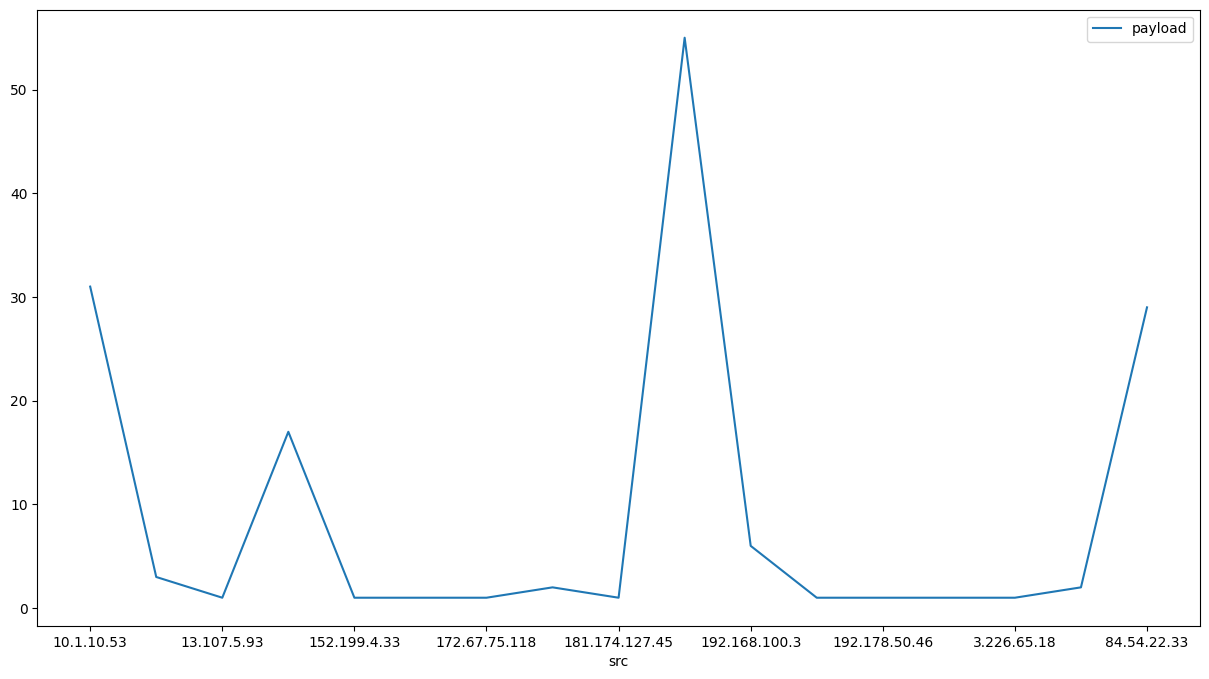

In [17]:
df.groupby('src').count()['payload'].plot(legend=True, figsize=(15, 8))

<Axes: xlabel='dst'>

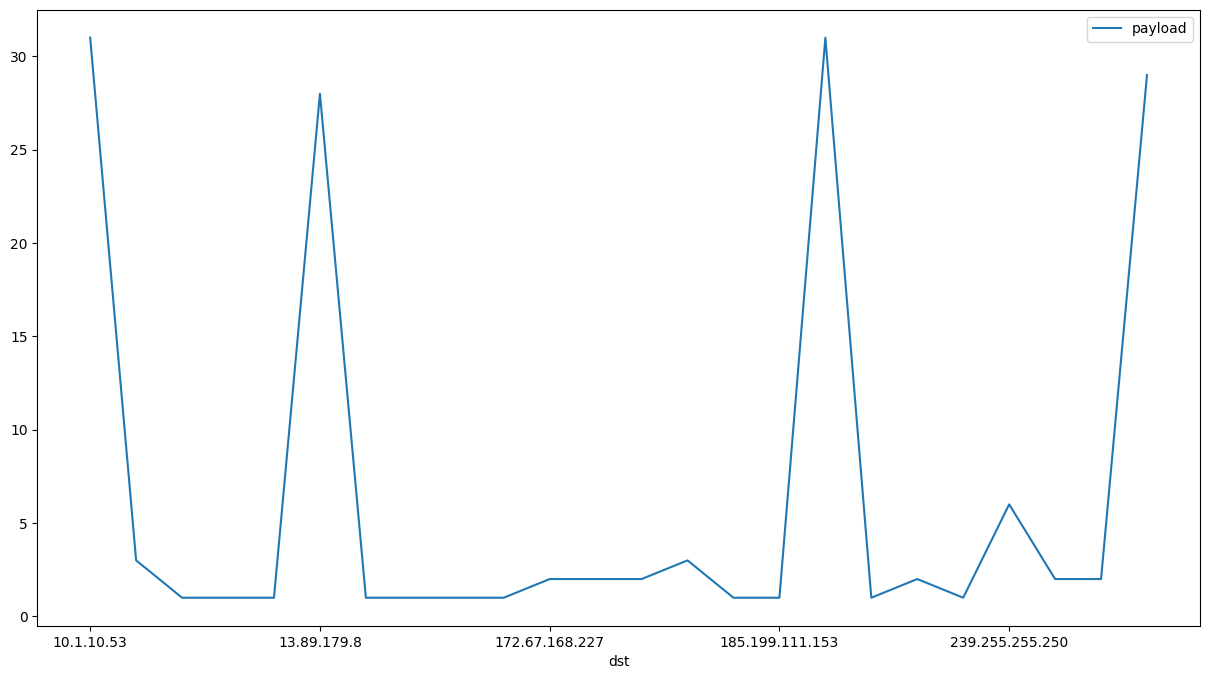

In [18]:
df.groupby('dst').count()['payload'].plot(legend=True, figsize=(15, 8))

<Axes: xlabel='sport'>

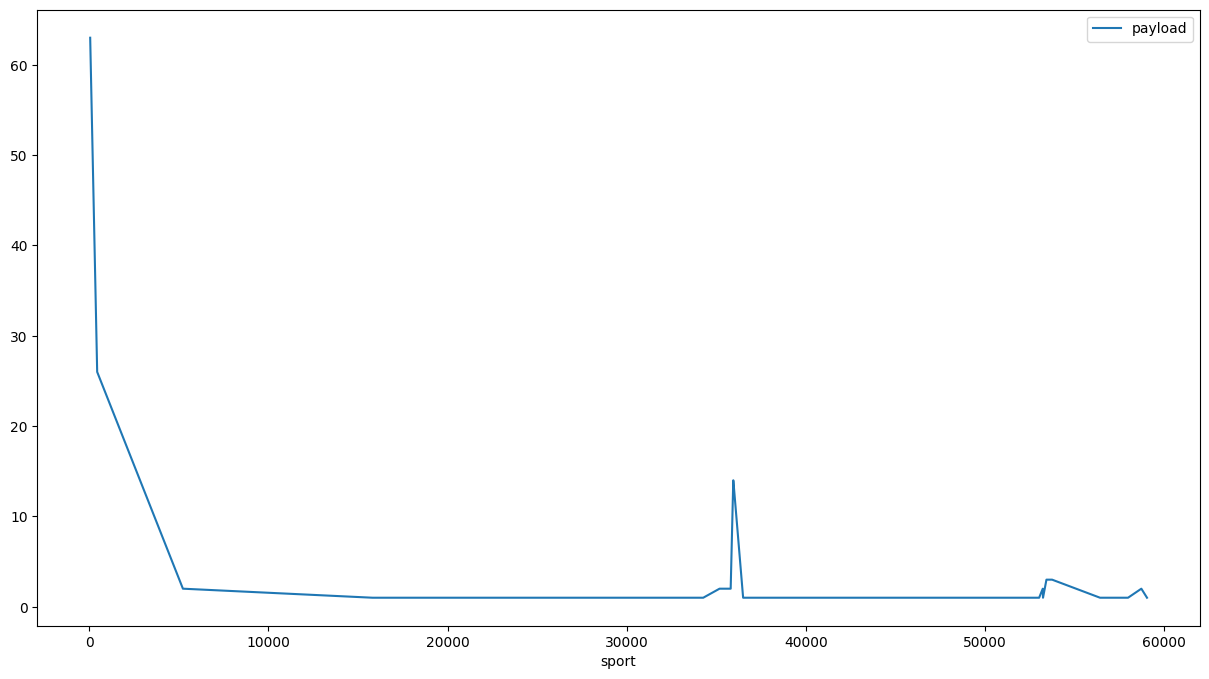

In [19]:
df.groupby('sport').count()['payload'].plot(legend=True, figsize=(15, 8))

<Axes: xlabel='dport'>

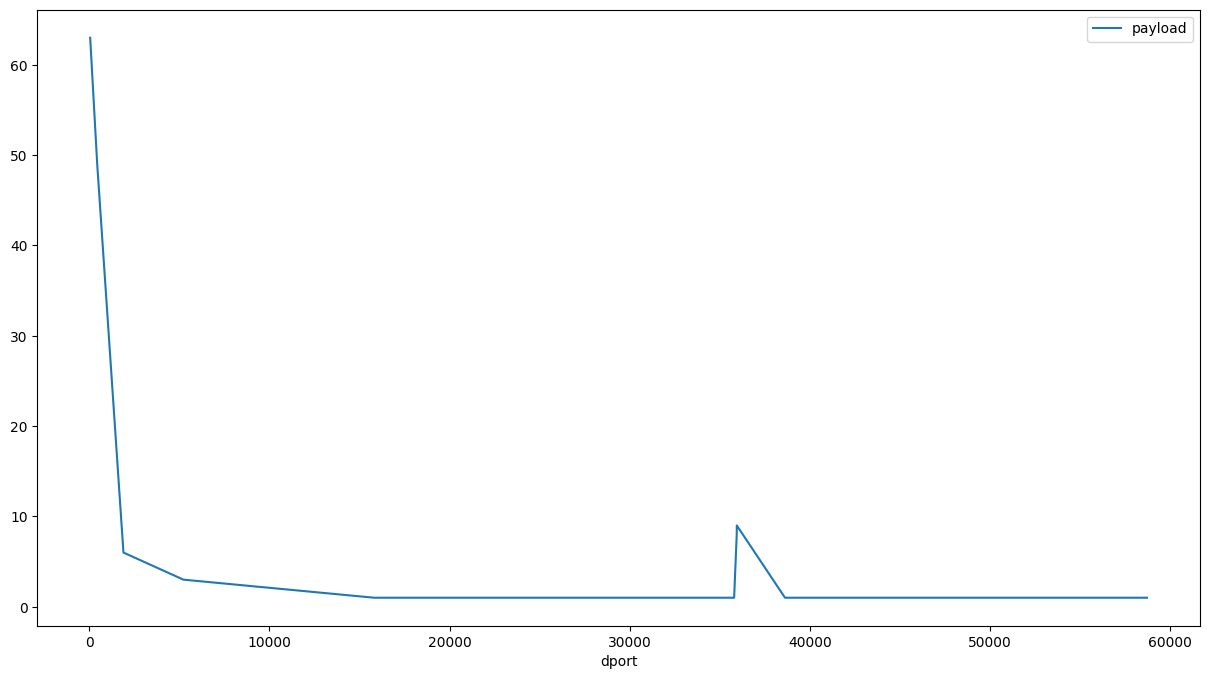

In [20]:
df.groupby('dport').count()['payload'].plot(legend=True, figsize=(15, 8))

In [21]:
df_src_frecuente = df[df['src'] == frequent_src_address]

df_src_frecuente.head()

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
62,4,5,0,102,20211,,0,64,17,3831,...,None,None,None,None,7425,None,None,74,b'\x9d\x03\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'9d0301000001000000000001106f6e656473636f6c70...
63,4,5,0,102,64225,,0,64,17,25352,...,None,None,None,None,7425,None,None,74,b'Y^\x01\x00\x00\x01\x00\x00\x00\x00\x00\x01\x...,b'595e01000001000000000001106f6e656473636f6c70...
66,4,5,0,60,22568,DF,0,64,6,24951,...,10,0,S,64240,33099,0,5,0,b'',b''
67,4,5,0,102,2130,,0,64,17,21912,...,None,None,None,None,7425,None,None,74,b'\x11\xb6\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'11b601000001000000000001106f6e656473636f6c70...
69,4,5,0,60,30932,DF,0,64,6,16587,...,10,0,S,64240,33099,0,5,0,b'',b''


In [22]:
df_payload = df_src_frecuente.groupby(by = ['payload'])
df_payload = df_payload[['src', 'dst', 'payload']]
df_payload.head()

,src,dst,payload
62,192.168.0.19,10.240.80.242,74
63,192.168.0.19,10.240.80.242,74
66,192.168.0.19,13.89.179.8,0
67,192.168.0.19,10.240.80.242,74
69,192.168.0.19,13.89.179.8,0
71,192.168.0.19,13.89.179.8,0
72,192.168.0.19,13.89.179.8,517
74,192.168.0.19,13.89.179.8,0
75,192.168.0.19,13.89.179.8,517
77,192.168.0.19,13.89.179.8,0


In [23]:
max_payload = max(df_src_frecuente['payload'])

print(max_payload)

1440


In [24]:
suspicious = df_src_frecuente[df_src_frecuente['payload'] == max_payload]['dst'].unique()[0]

print(suspicious)

13.89.179.8


In [25]:
suspiciousDf = df[(df['src'] == frequent_src_address) & (df['dst'] == suspicious)]
suspiciousDf.sample(5)

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
71,4,5,0,40,22569,DF,0,64,6,24970,...,5,0,A,502,33079,0,None,0,b'',b''
96,4,5,0,1480,30940,DF,0,64,6,15159,...,5,0,A,501,34519,0,0,1440,b'\xa6h\x18\x13\xe8\xa3W\n\xa5\x86\x9d\xff\x84...,b'a6681813e8a3570aa5869dff8425544a5f5223cb7819...
90,4,5,0,1480,22577,DF,0,64,6,23522,...,5,0,PA,501,34519,0,0,1440,b'\xf4\xc16!T\xa6\x98\xbe^\x0c\x1e\x98B\xde\x8...,b'f4c1362154a698be5e0c1e9842de81738409a61a43e0...
98,4,5,0,1480,30942,DF,0,64,6,15157,...,5,0,A,501,34519,0,0,1440,b'\xc8t4\x9d\xff1]{\x99\x93\xf4#\xf0A\x84\xc9\...,b'c874349dff315d7b9993f423f04184c9b492c00dcec9...
110,4,5,0,40,30945,DF,0,64,6,16594,...,5,0,FA,501,33079,0,None,0,b'',b''


In [26]:
payload_array = suspiciousDf['payload_raw'].to_numpy()

In [27]:
payload_array

array([b'', b'', b'',
       b'\x16\x03\x01\x02\x00\x01\x00\x01\xfc\x03\x03\xd8\x8a\x0f@\x8d\xcfbX\xfbV\x17U\xeb\xc6\xc5\x9a\x97*\xe5\xd3_\xd9\xe9f\xf0#`\xd2zRcl \xa4\x1e\x00\x00\xbc\xdex0-\xa0\x99\x8b\x7f!\xee\x91\xfd\x88\xdc\xd3\xae\xe5\x96#\x10\x90\x17\xf8\x8f\xa2\xdfD\x00$\x13\x03\x13\x01\x13\x02\xc0/\xc0+\xc00\xc0,\xcc\xa9\xcc\xa8\xc0\t\xc0\x13\xc0\n\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x00\n\x01\x00\x01\x8f\x00\x00\x00%\x00#\x00\x00 mobile.events.data.microsoft.com\x00\x17\x00\x00\xff\x01\x00\x01\x00\x00\n\x00\x08\x00\x06\x00\x1d\x00\x17\x00\x18\x00\x0b\x00\x02\x01\x00\x00#\x00\x00\x00\r\x00\x14\x00\x12\x04\x03\x08\x04\x04\x01\x05\x03\x08\x05\x05\x01\x08\x06\x06\x01\x02\x01\x003\x00&\x00$\x00\x1d\x00 \x10\xe2\x9f\xd9\xa6`(]Py\xf8r2\xff\xe5\x96\xc0\xf5\x1f\xea\x9ep~\x06\xdc]Z`\x01\xcaa2\x00-\x00\x02\x01\x01\x00+\x00\x05\x04\x03\x04\x03\x03\x00\x15\x00\xf2\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [28]:
suspiciousDf[['payload', 'payload_raw', 'src', 'sport', 'dst', 'dport']]

,payload,payload_raw,src,sport,dst,dport
66,0,b'',192.168.0.19,35942,13.89.179.8,443
69,0,b'',192.168.0.19,35946,13.89.179.8,443
71,0,b'',192.168.0.19,35942,13.89.179.8,443
72,517,b'\x16\x03\x01\x02\x00\x01\x00\x01\xfc\x03\x03...,192.168.0.19,35942,13.89.179.8,443
74,0,b'',192.168.0.19,35946,13.89.179.8,443
75,517,"b""\x16\x03\x01\x02\x00\x01\x00\x01\xfc\x03\x03...",192.168.0.19,35946,13.89.179.8,443
77,0,b'',192.168.0.19,35942,13.89.179.8,443
79,0,b'',192.168.0.19,35942,13.89.179.8,443
81,0,b'',192.168.0.19,35946,13.89.179.8,443
82,158,b'\x16\x03\x03\x00f\x10\x00\x00ba\x04\xf4\xc3t...,192.168.0.19,35942,13.89.179.8,443


#### Examine los primeros bytes del contenido, ¿encuentra algún dato que no haga sentido que se envié a través del puerto explicado en el inciso f?
No, todos los datos nos hacen sentido pues entran y van a los mismos puertos y direcciones

## Parte 2

In [32]:
df = pd.read_csv('Train_data.csv')

In [33]:
df.sample(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
16983,0,udp,other,SF,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.00,1.0,0.0,0.00,2,2,1.00,0.00,0.50,0.00,0.00,0.00,0.0,0.0,anomaly
11346,0,tcp,http,SF,262,3865,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,23,0.0,0.0,0.0,0.04,1.0,0.0,0.13,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,normal
22996,0,tcp,http,SF,222,1206,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,26,27,0.0,0.0,0.0,0.00,1.0,0.0,0.07,26,255,1.00,0.00,0.04,0.01,0.00,0.00,0.0,0.0,normal
16900,0,tcp,smtp,SF,2571,327,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.00,1.0,0.0,0.00,255,135,0.53,0.03,0.00,0.00,0.01,0.01,0.0,0.0,normal
3432,0,tcp,http,SF,255,1249,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,4,0.0,0.0,0.0,0.00,1.0,0.0,0.50,81,255,1.00,0.00,0.01,0.02,0.00,0.00,0.0,0.0,normal


In [35]:
prof = ProfileReport(df)
prof.to_file(output_file='reporte.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00,  9.89it/s]


In [41]:
for i in df.columns:
    # print(i, len(df[i].unique()))
    if len(df[i].unique()) < 70:
        label_encoder = LabelEncoder()
        df[i] = label_encoder.fit_transform(df[i])
        df[i] = df[i].astype('category')

In [42]:
X = df.drop(['class'], axis=1)
y = df['class']

In [43]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.33, random_state = 31)

In [44]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [45]:
pca = PCA(n_components = 0.60, random_state = 133)

In [46]:
pca.fit(X_train)
pca.fit(X_test)

PCA(n_components=0.6, random_state=133)

In [47]:
pca.n_components_

2

In [48]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [60]:
rbf_svc_pca = SVC(random_state = 7)

In [61]:
rbf_svc_pca.fit(X_train_pca, y_train)

SVC(random_state=7)

In [62]:
rbf_svc_pca.score(X_test_pca, y_test)

0.932523454414241

In [63]:
pred_pca = rbf_svc_pca.predict(X_test_pca)

In [64]:
print(metrics.accuracy_score(y_test, pred_pca))

0.932523454414241


In [65]:
print('Matriz de confusion \n', metrics.confusion_matrix(y_test, pred_pca))

Matriz de confusion 
 [[3467  412]
 [ 149 4286]]


In [66]:
confMatrix = confusion_matrix(y_test, pred_pca)

<Axes: >

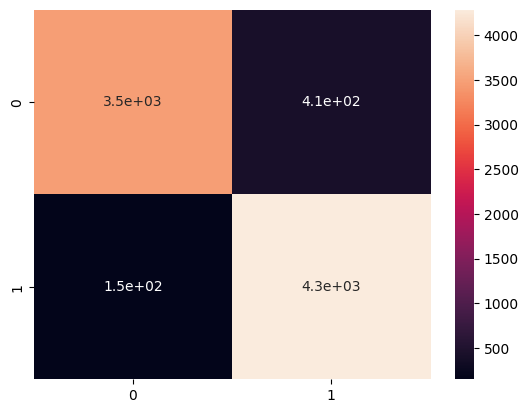

In [67]:
sns.heatmap(confMatrix, annot=True)

In [68]:
print(metrics.classification_report(y_test, pred_pca, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.96      0.89      0.93      3879
           1       0.91      0.97      0.94      4435

    accuracy                           0.93      8314
   macro avg       0.94      0.93      0.93      8314
weighted avg       0.93      0.93      0.93      8314



In [49]:
model = LogisticRegression()
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [50]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [51]:
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)

accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)

In [71]:
print("Accuracy train:",accuracy_train)
print("Precision train:",precision_train)
print("Recall train:",recall_train)

print("Accuracy test:",accuracy_test)
print("Precision test:",precision_test)
print("Recall test:",recall_test)

Accuracy train: 0.9533712525180709
Precision train: 0.946779624198979
Recall train: 0.9670512536055026
Accuracy test: 0.9579023334135194
Precision test: 0.9517805795178058
Recall test: 0.9702367531003382


In [55]:
confusion_train = confusion_matrix(y_train, y_train_pred)
confusion_test = confusion_matrix(y_test, y_test_pred)

<Axes: >

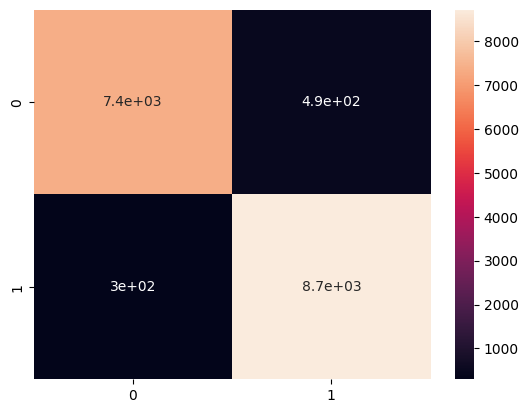

In [58]:
sns.heatmap(confusion_train, annot=True)

<Axes: >

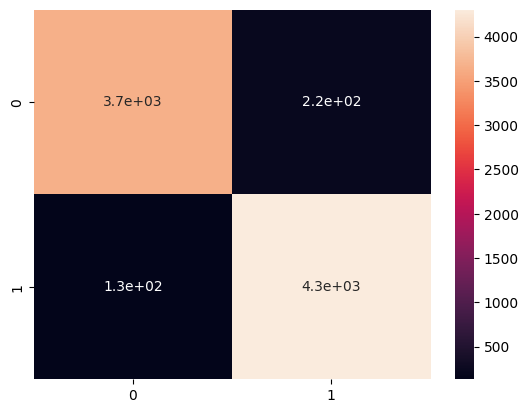

In [59]:
sns.heatmap(confusion_test, annot=True)